In [1]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    
   
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "cardiac1", data_nomi = "cardiac")


Dataset yuklab olingan. cardiac1/cardiac papkasini ni tekshiring.


In [7]:
import cv2
import torch
import os
from torch.utils.data import Dataset, DataLoader , random_split
from torchvision import transforms as T
from glob import glob

class CardiacDataset(Dataset):
    def __init__(self, root, transformations=None):
        super().__init__()
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path = sorted(glob(os.path.join(f"{root}/images/*")))
        self.gt_path = sorted(glob(os.path.join(f"{root}/labels/*")))
        
        print(len(self.im_path))
        print(len(self.gt_path))
        

    def __len__(self):
        return len(self.im_path)

    def __getitem__(self, idx):
        im_path = self.im_path[idx]
        gt_path = self.gt_path[idx]
        print(im_path)
        print(gt_path)
        
        im = cv2.imread(im_path)
        gt = cv2.imread(gt_path)

        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)

        if self.transformations:
            transformed = self.transformations(image=im, mask=gt)
            im = transformed["image"]
            gt = transformed["mask"]

        gt = (gt > 128)
        gt = torch.tensor(gt).long()
        
        im = self.tensorize(im)

        return im, gt
    

ds = CardiacDataset(root="cardiac1/cardiac/cardiac")


print(ds[0][0].shape)
im, gt = ds[0]
print(torch.unique(gt))



# print(ds[0][0].shape)






1717
1717
cardiac1/cardiac/cardiac/images\1.png
cardiac1/cardiac/cardiac/labels\1.png
torch.Size([3, 512, 512])
cardiac1/cardiac/cardiac/images\1.png
cardiac1/cardiac/cardiac/labels\1.png
tensor([0, 1])


In [8]:
import albumentations as A # array

def get_transformations(size):
    
    return [A.Compose([A.Resize(size, size),
                      A.HorizontalFlip(0.5),
                      A.VerticalFlip(0.5),
                      A.GaussNoise(0.2)]),
                     A.Compose([A.Resize(size, size)])]
tr_ts, ts_ts = get_transformations(size = 224)
tr_ts, ts_ts


(Compose([
   Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
   HorizontalFlip(always_apply=0.5, p=0.5),
   VerticalFlip(always_apply=0.5, p=0.5),
   GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.2), per_channel=True, mean=0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
 Compose([
   Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True))

cardiac1/cardiac/cardiac/images\1.png
cardiac1/cardiac/cardiac/labels\1.png
Original Rasm


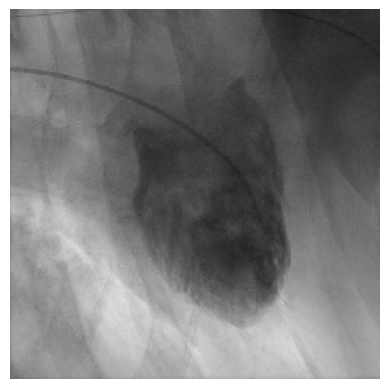

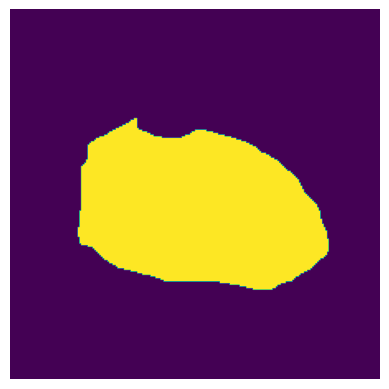

cardiac1/cardiac/cardiac/images\10.png
cardiac1/cardiac/cardiac/labels\10.png
Original Rasm


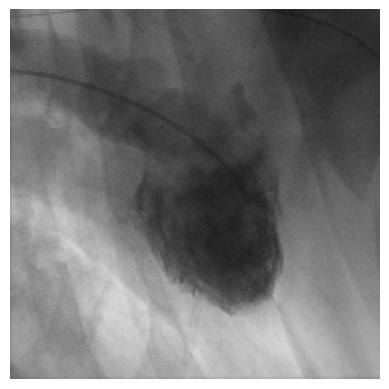

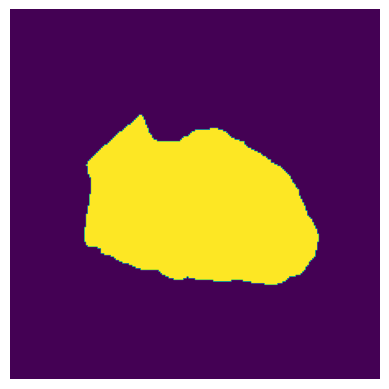

cardiac1/cardiac/cardiac/images\100.png
cardiac1/cardiac/cardiac/labels\100.png


In [9]:
from PIL import Image 
from matplotlib import pyplot as plt 
size = 224
for i , data in enumerate (ds):
    if i == 2:break 
    im , gt = data 
    print("Original Rasm")
    plt.imshow(cv2.resize(im.permute(2,1,0).numpy(), (size, size))); plt.axis("off"); plt.show()
    plt.imshow(cv2.resize(gt.numpy().astype('uint8'), (size, size))); plt.axis("off"); plt.show()

In [10]:
def get_dls(root, transformations, bs, split = [0.7, 0.15, 0.15], ns = 0):
    
    ds = CardiacDataset(root = root, transformations = transformations)
    tr_length = len(ds)
    tr_len = int(tr_length * split[0])  # 16 * 0.7 = float -> int
    val_len = int(tr_length * split[1]) # 16 * 015 = float -> int
    ts_len = tr_length - tr_len - val_len
    
    print(f"Train datasetdagi datalar soni -> {tr_len}")
    print(f"Validation datasetdagi datalar soni -> {val_len}")
    print(f"Test datasetdagi datalar soni -> {ts_len}")
    
    tr_ds, val_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, val_len, ts_len])
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    ts_dl = DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl
    
tr_dl, val_dl, ts_dl = get_dls(root = "cardiac1/cardiac/cardiac", transformations = ts_ts, bs = 8)

1717
1717
Train datasetdagi datalar soni -> 1201
Validation datasetdagi datalar soni -> 257
Test datasetdagi datalar soni -> 259


In [11]:
print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))

151
33
259


In [12]:
import torch
from torch import nn
from torch.nn import functional as F

class UNetBlock(nn.Module):
    
    def __init__(self, in_chs, out_chs, ks = 3, p = 1):
        super().__init__()
        
        self.ks, self.p = ks, p
        
        self.block_1 = self.get_conv_block(in_chs = in_chs, out_chs = out_chs)
        self.block_2 = self.get_conv_block(in_chs = out_chs, out_chs = out_chs)
        
        
    def get_conv_block(self, in_chs, out_chs):
        
        return nn.Sequential(nn.Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = self.ks, padding = self.p),
                             nn.BatchNorm2d(num_features = out_chs), nn.ReLU(inplace = True))
    
    def forward(self, inp): return self.block_2(self.block_1(inp))

class DownSampling(nn.Module):
    
    def __init__(self, in_chs, out_chs):
        super().__init__()
        
        self.downsample_block = nn.Sequential( nn.MaxPool2d(2), UNetBlock(in_chs = in_chs, out_chs = out_chs))
        
    def forward(self, inp): return self.downsample_block(inp)


class UpSampling(nn.Module):
    def __init__(self, in_chs, out_chs, mode, upsample = None):
        super().__init__()
        
        if mode in ["bilinear", "nearest"]:
            upsample = True
            up_mode = mode
            
        self.upsample = nn.Upsample(scale_factor = 2, mode = up_mode) if upsample else nn.ConvTranspose2d(in_channels = in_chs, out_channels = in_chs // 2, kernel_size = 2, stride = 2)
        self.conv = UNetBlock(in_chs = in_chs, out_chs = out_chs)
        
    def forward(self, inp1, inp2):
        
        inp1 = self.upsample(inp1)
        # Padding
        pad_y = inp2.shape[2] - inp1.shape[2]
        pad_x = inp2.shape[3] - inp1.shape[3]
        inp1 = F.pad(inp1, [pad_x // 2, pad_x - pad_x // 2, pad_y // 2, pad_y - pad_y // 2])
        concat = torch.cat([inp1, inp2], dim = 1)
        
        return self.conv(concat)
    
class FinalConv(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = 1)
        
    def forward(self, inp): return self.conv(inp)

class UNet(nn.Module):
    
    def __init__(self, in_chs, n_cls, out_chs, up_method):
        super().__init__()
        
        assert up_method in ["bilinear", "nearest", "tr_conv"], "Please choose a proper method for upsampling!"
        
        self.init_block = UNetBlock(in_chs, out_chs, ks = 3, p = 1)
        
        factor = 2 if up_method in ["bilinear", "nearest"] else 1
        
        # Encoder blocks
        self.enc_block_1 = DownSampling(out_chs, out_chs * 2)
        self.enc_block_2 = DownSampling(out_chs * 2, out_chs * 4)
        self.enc_block_3 = DownSampling(out_chs * 4, out_chs * 8)
        self.enc_block_4 = DownSampling(out_chs * 8, out_chs * 16 // factor)
        
        # Decoder blocks
        self.dec_block_1 = UpSampling(out_chs * 16, out_chs * 8 // factor, up_method) 
        self.dec_block_2 = UpSampling(out_chs * 8, out_chs * 4 // factor, up_method)
        self.dec_block_3 = UpSampling(out_chs * 4, out_chs * 2 // factor, up_method)
        self.dec_block_4 = UpSampling(out_chs * 2, (out_chs // factor) * 2 if up_method in ["bilinear", "nearest"] else (out_chs // factor), up_method)
        self.final_conv = FinalConv(out_chs, n_cls)
        
    def forward(self, inp):
        
        init_conv = self.init_block(inp)
        
        enc_1 = self.enc_block_1(init_conv)
        enc_2 = self.enc_block_2(enc_1)
        enc_3 = self.enc_block_3(enc_2)
        enc_4 = self.enc_block_4(enc_3)
        
        dec_1 = self.dec_block_1(enc_4, enc_3)
        dec_2 = self.dec_block_2(dec_1, enc_2)
        dec_3 = self.dec_block_3(dec_2, enc_1)
        dec_4 = self.dec_block_4(dec_3, init_conv)
        
        return self.final_conv(dec_4)
    
    
inp = torch.rand(1,3,224, 224)
model = UNet(in_chs = 3, n_cls = 2, out_chs = 64, up_method = 'tr_conv')
# model = UNet(3,2, 64, 'nearest')
print(model(inp).shape)
# print(model)

torch.Size([1, 2, 224, 224])


In [13]:
class Metrics():
    def __init__ (self, pred ,gt, loss_fn , n_cls = 2):
        self.pred=torch.argmax (torch.nn.functional.softmax (pred, dim = 1), dim = 1 )
        self.gt = gt 
        self.loss_fn = loss_fn 
        self.n_cls = n_cls 
        self.pred_ = pred 
        
  
        
    def to_contiguous (self,inp) : return inp.contiguous().view(-1)
    
    def PA (self):
    
        with torch.no_grad():
            match = torch.eq(self.pred , self.gt).int() 
        return float(match.sum()) / float(match.numel())
    
    def mIoU (self):
        
        with torch.no_grad():
            pred , gt = self.to_contiguous (self.pred), self.to_contiguous(self.gt)
            iou_per_class = []
            
            for c in range (self.n_cls):
                match_pred = pred == c 
                match_gt = gt == c 
                
                
                if match_gt.long().sum().item() == 0 : iou_per_class.append(np.nan) 
                else : 
                    
                    intersection = torch.logical_and (match_pred , match_gt).sum().float().item()
                    union = torch.logical_or (match_pred , match_gt).sum().float().item()
                    
                    iou = (intersection ) / (union)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
        
    def loss(self) :   return  self.loss_fn(self.pred_, self.gt)       




In [14]:
import time 
import os , numpy as np

def tic_toc(start_time=None): 
    return time.time() if start_time is None else time.time() - start_time  

def train(tr_dl, val_dl, model, device, loss_fn, epochs, opt, save_prefix):
    tr_loss, tr_pa, tr_iou = [], [], [] 
    val_loss, val_pa, val_iou = [], [], []
    
    tr_len, val_len = len(tr_dl), len(val_dl) 
    best_loss = np.inf
    os.makedirs("modellar", exist_ok=True)
    model.to(device)
    train_start = tic_toc()
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        model.train()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        print(f"{epoch} - epoch train jarayonlari boshlanish arafasida ...")
        
        for i, batch in enumerate(tr_dl): 
            # if i == 1:
            #     break 
            ims, gts = batch 
            ims, gts = ims.to(device), gts.to(device) 
                
            bashoratlar = model(ims)
                
            met = Metrics(gt=gts, pred=bashoratlar, loss_fn=loss_fn, n_cls=2) 
                
            loss_ = met.loss()
            tr_loss_ += loss_
            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
                
            opt.zero_grad()
            loss_.backward()
            opt.step()
                
        print(f"{epoch} - epoch validation jarayoni boshlanish arafasida ...")     
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        
        with torch.no_grad():
            for i, batch in enumerate(val_dl): 
                ims, gts = batch 
                ims, gts = ims.to(device), gts.to(device) 
                
                bashoratlar = model(ims)
                
                met = Metrics(gt=gts, pred=bashoratlar, loss_fn=loss_fn, n_cls=2) 
                
                val_loss_ += met.loss()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                
        print(f"{epoch} - epoch validation jarayoni yakunlandi ...")     
        
        tr_len = len(tr_dl); val_len= len(val_dl)
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
        print(f"\n{epoch} train jarayoni natijalari \n")
        print(f"Train vaqti              -> {tic_toc(tic):.3f} sek")
        print(f"Train xatolik            -> {tr_loss_:.3f} ")
        print(f"Train PA                 -> {tr_pa_:.3f} ")
        print(f"Train mIoU               -> {tr_iou_:.3f} ")
        print(f"Validation Xatolik       -> {val_loss_:.3f} ")
        print(f"Validation PA            -> {val_pa_:.3f} ")
        print(f"Validation mIoU          -> {val_iou_:.3f}\n ")
        
        tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_);
        val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_);
        
        
        if val_loss_ < best_loss:
            print(f" Xatolik {best_loss:.3f} dan {val_loss_:.3f} ga kamaydi")
            best_loss = val_loss_
            torch.save(model, f"modellar/{save_prefix}_best_model.pt")
            
    print(f"Train jarayoni {((tic_toc(train_start)) / 60):.3f} daqiqada yakunlandi!!!")      
    
# Assuming tr_dl, val_dl, and model are defined elsewhere
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(), lr=3e-4)
train(tr_dl=tr_dl, val_dl=val_dl, model=model, device=device, epochs=5, loss_fn=loss_fn, opt=opt, save_prefix="cardiac")


1 - epoch train jarayonlari boshlanish arafasida ...
cardiac1/cardiac/cardiac/images\450.png
cardiac1/cardiac/cardiac/labels\450.png
cardiac1/cardiac/cardiac/images\498.png
cardiac1/cardiac/cardiac/labels\498.png
cardiac1/cardiac/cardiac/images\725.png
cardiac1/cardiac/cardiac/labels\725.png
cardiac1/cardiac/cardiac/images\367.png
cardiac1/cardiac/cardiac/labels\367.png
cardiac1/cardiac/cardiac/images\486.png
cardiac1/cardiac/cardiac/labels\486.png
cardiac1/cardiac/cardiac/images\1712.png
cardiac1/cardiac/cardiac/labels\1712.png
cardiac1/cardiac/cardiac/images\966.png
cardiac1/cardiac/cardiac/labels\966.png
cardiac1/cardiac/cardiac/images\1131.png
cardiac1/cardiac/cardiac/labels\1131.png
cardiac1/cardiac/cardiac/images\730.png
cardiac1/cardiac/cardiac/labels\730.png
cardiac1/cardiac/cardiac/images\1553.png
cardiac1/cardiac/cardiac/labels\1553.png
cardiac1/cardiac/cardiac/images\1102.png
cardiac1/cardiac/cardiac/labels\1102.png
cardiac1/cardiac/cardiac/images\1298.png
cardiac1/cardiac/c

cardiac1/cardiac/cardiac/images\1172.png
cardiac1/cardiac/cardiac/labels\1172.png


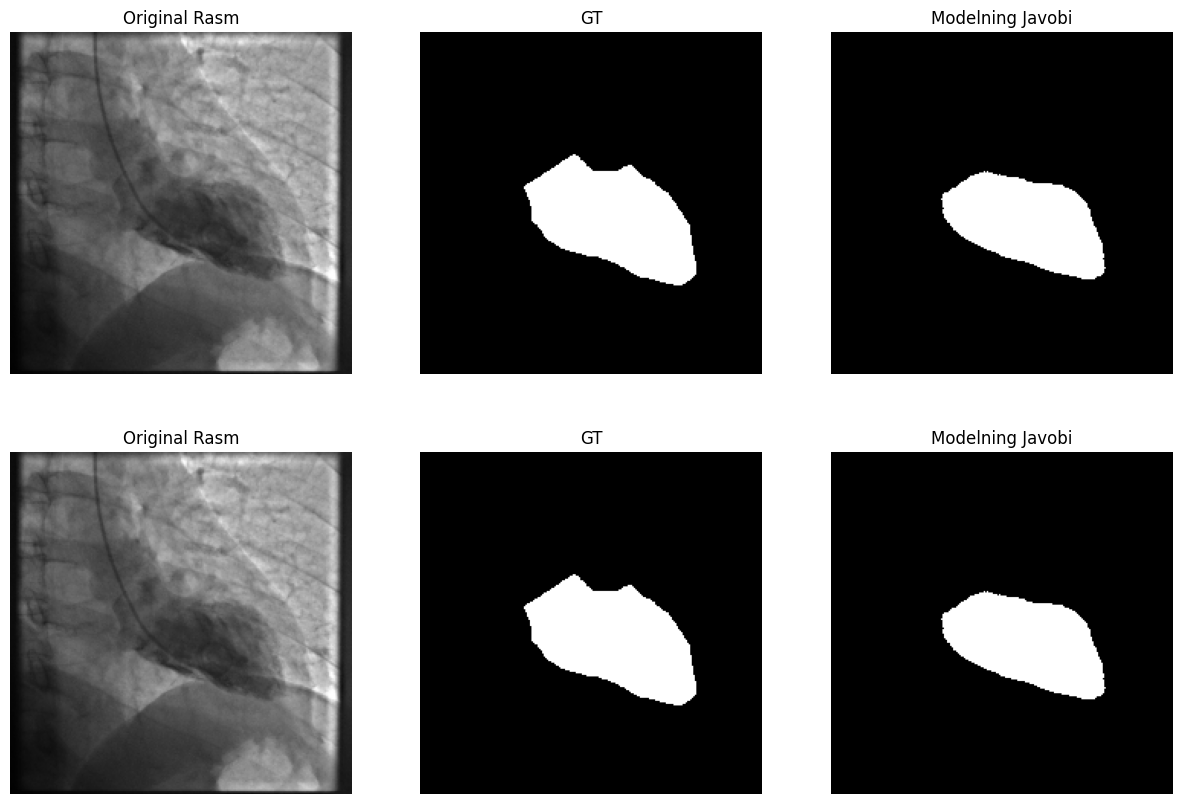

In [31]:
from matplotlib import pyplot as plt 
def tn_2_np(t): return (t*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if len(t) == 3 else (t*255).detach().cpu().numpy().astype(np.uint8)


model = torch.load("modellar/cardiac_best_model.pt")
def inference (dl, model , device):
    
    count =1 
    
    for i , batch in enumerate (dl):
        
        # if i == 2: break 
        
         
        
        
        im, gt = batch 
        bashorat = model(im.to(device))
        
        
        plt.figure (figsize = (15, 10))
        
        plt.subplot (2, 3 , count)
        plt.imshow(tn_2_np(im.squeeze (0)), cmap = "gray")
        plt.axis("off"); plt.title("Original Rasm")
        
        count +=1
        
        plt.subplot (2, 3 , count)
        plt.imshow(gt.squeeze (0), cmap = "gray")
        plt.axis("off"); plt.title("GT")
        
        count += 1 
        
        plt.subplot (2, 3 , count)
        plt.imshow(tn_2_np((bashorat >0.5).squeeze (0))[1], cmap = "gray")
        plt.axis("off"); plt.title("Modelning Javobi")
        
        count += 1
        
        
        plt.subplot (2, 3 , count)
        plt.imshow(tn_2_np(im.squeeze (0)), cmap = "gray")
        plt.axis("off"); plt.title("Original Rasm")
        
        count +=1
        
        plt.subplot (2, 3 , count)
        plt.imshow(gt.squeeze (0), cmap = "gray")
        plt.axis("off"); plt.title("GT")
        
        count += 1 
        
        plt.subplot (2, 3 , count)
        plt.imshow(tn_2_np((bashorat >0.5).squeeze (0))[1], cmap = "gray")
        plt.axis("off"); plt.title("Modelning Javobi")
        
        count += 1
        break
        
        
model = torch.load("modellar/cardiac_best_model.pt").to(device)
# model = UNet(in_chs = 3, n_cls = 2, out_chs = 64, up_method = 'tr_conv').to(device)
inference(dl = ts_dl , device = device , model = model )
        